# Introducción

[Clutch](https://clutch.co/) es un sitio B2B (Negocio a negocio, del inglés business-to-business o B2B) de calificaciones y reseñas de empresas tecnológicas. Aquí, éstas son evaluadas en función de una serie de factores cuantitativos y cualitativos entre las que se encuentran reseñas certificadas que realizan sus cliente. Permite constituir una reputación a través de revisiones verificadas de terceros.

No solo es relevante como punto de consulta de información valiosa para la ponderación de proveedores; sino también, como se pretende en el presente, hacer un análisis de la presencia de la competencia en el mercado para establecer puntos de comparación.

# Objetivo

Con este desarrollo se aspira a extraer referencias allí expuesta para constituir una radiografía del mercado. La intensión es simplificar la información en un cuadrante de posicionamiento que permita una rápida comparativa de las empresas que operan en un mismo área (delimitada por rubro y geografía).

La principales técnicas a utilizar son: Web Scraping para recopilar información de forma automática expuesta en Internet, y Text Mining para preprocesar los datos no estructurados obtenidos del portal citado.

# Alcance

El entregable que resulta de este trabajo supone:

- Una pieza de código automatizable que extraiga el texto tal como se expone en el sitio web.
- Preprocesamiento de los registros utilizando técnicas de Text Mining para obtener un set de datos estructurados.
- Reconocer las entidades relevantes de cada lectura para disponer el resultado en forma adecuada para la construcción el resumen pretendido. 

# Consideraciones (a completar)

describir los aspectos a tener en cuenta cuando se hace scraping: CAPTCHA, contenido dinámico, etc.

# Resto de tareas (a completar) 

Cron en hosting
Monitoreo: agente externo para ver si anda -> si anda, me autochequeo
Resolver la caida de internet -> por ejemplo, reintentando
Resolver errores html (40, 50)
Chequear que la estructura cambio o no
Describir cómo construir el dashboard sin construir nada
...

# Futuras lineas de trabajo (a completar)

Extender el origen de información a otros sitios que brinde un servicio de idénticas características.

# Desarrollo

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests
import pandas as pd
import seaborn as sns

from re import sub
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from typing import Iterable, Union

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Categorías

In [3]:
categories = ['app-developers', 'web-developers', 'developers']

## Utilidades

In [4]:
def get_search_page(category: str, page_number: int) -> BeautifulSoup:
  clutch_argentina = requests.get(f'https://clutch.co/ar/{category}?page={page_number}')
  return BeautifulSoup(clutch_argentina.text)

def get_company_profile(profile_link: str) -> BeautifulSoup:
  profile = requests.get(f'https://clutch.co/{profile_link}')
  return BeautifulSoup(profile.text)

def is_last_page(beautiful_soup_page: BeautifulSoup) -> bool:
  return not beautiful_soup_page.select('li.page-item.last > a')

def get_element_text_if_exists(elements: Iterable) -> Union[str, None]:
  if elements is not None and len(elements) > 0:
    return elements[0].text.strip()

def snake_case(value: str) -> str:
  return '_'.join(sub('[^0-9a-zA-Z\s\_]+', '', value).split()).lower()

In [5]:
def create_row(provider_li: BeautifulSoup) -> dict:
    row = {}
    
    company_info = provider_li.select('h3.company_info a')
    row['company_name'] = get_element_text_if_exists(company_info)
    row['rating'] = get_element_text_if_exists(provider_li.select('.rating'))
    row['reviews'] = get_element_text_if_exists(provider_li.select('.reviews-link'))

    #Min. project size, Avg. hourly rate, Employees, Location
    items = provider_li.select('.module-list > div')
    for item in items:
      key_name = BeautifulSoup(item.attrs['data-content']).text
      row[key_name] = get_element_text_if_exists(item.select('span'))

    #Service Focus
    percentages = provider_li.select('.chartAreaContainer > div')
    for percentage in percentages:
      content = BeautifulSoup(percentage.attrs['data-content'])
      row[f'service_focus_{content.b.text}'] = content.i.text

    #Client focus
    profile_link = provider_li.select('li.website-profile > a')[0].attrs['href']
    profile = get_company_profile(profile_link)
    client_focus = profile.find("div", string='Client focus')

    if client_focus:
      for client in client_focus.find_next_sibling().select('div.grid.custom_popover'):
        key_name = BeautifulSoup(client.attrs['data-content']).b.text
        row[f'client_focus_{key_name}'] = client.text
      
    return row

## Scraping

In [6]:
def get_companies(category: str) -> pd.DataFrame:
  page_number = 0
  rows = []

  with tqdm() as pbar:
    pbar.set_description(f"Categoria: {category}")

    while True:
      pbar.update(1)

      page = get_search_page(category, page_number)
      company_list = page.select('ul.directory-list li.provider-row')
      rows += [create_row(company) for company in company_list]
      page_number += 1

      if is_last_page(page):
        break
    
  return pd.DataFrame(rows)

In [8]:
companies = []
for category in categories:
    companies.append(get_companies(category))

companies = pd.concat(companies)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [10]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development,client_focus_midmarket_10m_1b,client_focus_enterprise_1b,client_focus_small_business_10m,service_focus_artificial_intelligence,service_focus_application_testing,service_focus_architectural_design,service_focus_uxui_design,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_bi_big_data_consulting_si,service_focus_blockchain,service_focus_cloud_consulting_si,service_focus_erp_consulting_and_si,service_focus_ecommerce_development,service_focus_enterprise_app_modernization,service_focus_arvr_development,service_focus_crm_consulting_and_si,service_focus_social_media_marketing,service_focus_content_marketing,service_focus_digital_strategy,service_focus_web_design,service_focus_it_managed_services,service_focus_other,service_focus_other_it_consulting_and_si,service_focus_application_management_support,service_focus_iot_development,service_focus_product_design,service_focus_other_application_development,service_focus_search_engine_optimization,service_focus_graphic_design,service_focus_hr_services,service_focus_wearable_app_development,service_focus_email_marketing,service_focus_branding,service_focus_advertising,service_focus_logo,service_focus_video_production,service_focus_market_research,service_focus_pay_per_click,service_focus_cybersecurity,service_focus_accounting,service_focus_business_consulting,service_focus_translation,service_focus_other_design,service_focus_other_digital_marketing,service_focus_mobile_app_marketing,service_focus_sales_outsourcing,service_focus_media_planning_buying,service_focus_back_office_outsourcing,service_focus_conversion_optimization,service_focus_corporate_training,service_focus_marketing_strategy,service_focus_public_relations,service_focus_corporate_photography,service_focus_packaging_design,service_focus_print_design,service_focus_call_center_services,service_focus_customer_service_outsourcing,service_focus_ocean_freight,service_focus_logistics_supply_chain_consulting,service_focus_trucking,service_focus_air_freight,service_focus_freight_forwarding,service_focus_customs_brokerage,service_focus_commercial_financing_funding_investment,service_focus_unified_communications_consulting_si
0,404 // Software crafters,4.7,5 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Buenos Aires, Argentina",40%,30%,30%,80%,10%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Rootstrap,4.8,34 reviews,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",25%,10%,40%,40%,25%,35%,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Flux IT,4.9,11 reviews,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",30%,40%,30%,50%,25%,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The App Master,5.0,7 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Buenos Aires, Argentina",40%,30%,NaN,50%,20%,30%,NaN,10%,10%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Clarika,4.8,14 reviews,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",20%,30%,10%,70%,NaN,30%,NaN,NaN,NaN,NaN,30%,10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Cambiamos el nombre de las columnas para que sean snake_case

In [9]:
companies.columns = map(snake_case, companies.columns)

In [ ]:
companies.columns

## Preproceso

Podria ocurrir que una misma empresa puede estar en varias categorias. Tenemos datos duplicados? 

In [11]:
companies.duplicated().sum()

419

In [12]:
companies = companies.drop_duplicates()

Hay valores de columnas que no todas las empresas tendran. Tenemos valores nulos?

In [16]:
companies.columns[companies.isna().sum() == 0]

Index(['company_name', 'rating', 'reviews', 'min_project_size',
       'avg_hourly_rate', 'employees', 'location',
       'service_focus_mobile_app_development',
       'service_focus_custom_software_development',
       'service_focus_web_development', 'client_focus_midmarket_10m_1b',
       'client_focus_enterprise_1b', 'client_focus_small_business_10m',
       'service_focus_artificial_intelligence',
       'service_focus_application_testing',
       'service_focus_architectural_design', 'service_focus_uxui_design',
       'service_focus_it_staff_augmentation',
       'service_focus_it_strategy_consulting',
       'service_focus_bi_big_data_consulting_si', 'service_focus_blockchain',
       'service_focus_cloud_consulting_si',
       'service_focus_erp_consulting_and_si',
       'service_focus_ecommerce_development',
       'service_focus_enterprise_app_modernization',
       'service_focus_arvr_development', 'service_focus_crm_consulting_and_si',
       'service_focus_social_media_

In [17]:
companies = companies.fillna('0')

In [18]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development,client_focus_midmarket_10m_1b,client_focus_enterprise_1b,client_focus_small_business_10m,service_focus_artificial_intelligence,service_focus_application_testing,service_focus_architectural_design,service_focus_uxui_design,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_bi_big_data_consulting_si,service_focus_blockchain,service_focus_cloud_consulting_si,service_focus_erp_consulting_and_si,service_focus_ecommerce_development,service_focus_enterprise_app_modernization,service_focus_arvr_development,service_focus_crm_consulting_and_si,service_focus_social_media_marketing,service_focus_content_marketing,service_focus_digital_strategy,service_focus_web_design,service_focus_it_managed_services,service_focus_other,service_focus_other_it_consulting_and_si,service_focus_application_management_support,service_focus_iot_development,service_focus_product_design,service_focus_other_application_development,service_focus_search_engine_optimization,service_focus_graphic_design,service_focus_hr_services,service_focus_wearable_app_development,service_focus_email_marketing,service_focus_branding,service_focus_advertising,service_focus_logo,service_focus_video_production,service_focus_market_research,service_focus_pay_per_click,service_focus_cybersecurity,service_focus_accounting,service_focus_business_consulting,service_focus_translation,service_focus_other_design,service_focus_other_digital_marketing,service_focus_mobile_app_marketing,service_focus_sales_outsourcing,service_focus_media_planning_buying,service_focus_back_office_outsourcing,service_focus_conversion_optimization,service_focus_corporate_training,service_focus_marketing_strategy,service_focus_public_relations,service_focus_corporate_photography,service_focus_packaging_design,service_focus_print_design,service_focus_call_center_services,service_focus_customer_service_outsourcing,service_focus_ocean_freight,service_focus_logistics_supply_chain_consulting,service_focus_trucking,service_focus_air_freight,service_focus_freight_forwarding,service_focus_customs_brokerage,service_focus_commercial_financing_funding_investment,service_focus_unified_communications_consulting_si
0,404 // Software crafters,4.7,5 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Buenos Aires, Argentina",40%,30%,30%,80%,10%,10%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rootstrap,4.8,34 reviews,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",25%,10%,40%,40%,25%,35%,25%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Flux IT,4.9,11 reviews,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",30%,40%,30%,50%,25%,25%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The App Master,5.0,7 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Buenos Aires, Argentina",40%,30%,0,50%,20%,30%,0,10%,10%,10%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Clarika,4.8,14 reviews,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",20%,30%,10%,70%,0,30%,0,0,0,0,30%,10%,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Hay algunas columnas que son porcentajes pero en tipo string, vamos a reemplazarlos como variables numericas.

In [31]:
columns_no_porcentajes = ['company_name','rating', 'reviews', 'min_project_size', 'avg_hourly_rate', 'employees', 'location']

columns_porcetajes = companies.columns.difference(columns_no_porcentajes)

In [32]:
for column in columns_porcetajes:
  companies[column] = companies[column].str.replace('%', '')
  companies[column] = companies[column].astype(int)

In [33]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development,client_focus_midmarket_10m_1b,client_focus_enterprise_1b,client_focus_small_business,service_focus_artificial_intelligence,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_bi_big_data_consulting_si,service_focus_blockchain,service_focus_cloud_consulting_si,service_focus_application_testing,service_focus_architectural_design,service_focus_uxui_design,service_focus_erp_consulting_and_si,service_focus_ecommerce_development,service_focus_iot_development,service_focus_enterprise_app_modernization,service_focus_arvr_development,service_focus_crm_consulting_and_si,service_focus_other,service_focus_content_marketing,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_web_design,service_focus_it_managed_services,service_focus_other_it_consulting_and_si,service_focus_application_management_support,service_focus_product_design,service_focus_other_application_development,service_focus_search_engine_optimization,service_focus_graphic_design,service_focus_hr_services,service_focus_wearable_app_development,service_focus_branding,service_focus_email_marketing,service_focus_advertising,service_focus_logo,service_focus_video_production,service_focus_market_research,service_focus_pay_per_click,service_focus_cybersecurity,service_focus_accounting,service_focus_business_consulting,service_focus_translation,service_focus_other_design,service_focus_other_digital_marketing,service_focus_mobile_app_marketing,service_focus_sales_outsourcing,service_focus_media_planning_buying,service_focus_back_office_outsourcing,service_focus_conversion_optimization,service_focus_corporate_training,service_focus_marketing_strategy,service_focus_public_relations,service_focus_corporate_photography,service_focus_packaging_design,service_focus_print_design,service_focus_call_center_services,service_focus_customer_service_outsourcing,service_focus_ocean_freight,service_focus_logistics_supply_chain_consulting,service_focus_trucking,service_focus_air_freight,service_focus_freight_forwarding,service_focus_customs_brokerage,service_focus_commercial_financing_funding_investment,service_focus_unified_communications_consulting_si
0,404 // Software crafters,4.7,5 reviews,"$10,000+",$25 - $49 / hr,10 - 49,"Campo Salles, Argentina",40,30,30,80,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rootstrap,4.8,34 reviews,"$50,000+",$100 - $149 / hr,50 - 249,"Buenos Aires, Argentina",25,10,40,40,25,35,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Flux IT,4.9,10 reviews,"$10,000+",Undisclosed,50 - 249,"Gonnet, Argentina",30,40,30,50,25,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Clarika,4.8,14 reviews,"$10,000+",$25 - $49 / hr,50 - 249,"Córdoba, Argentina",20,30,10,70,0,30,0,30,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Azumo,4.9,10 reviews,"$25,000+",$25 - $49 / hr,50 - 249,"Rosario, Argentina",10,20,20,40,30,30,20,0,0,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


En el caso particualar de `reviews`, se le agrega la palabra `review/s` ademas del numero.
Vamos a quedarnos solo con el numero

In [34]:
companies['reviews'] = companies.reviews.str.replace('[reviews|review]', '').astype(int)

Tenemos muchas columnas que representan el `service_focus` y `client_focus`.

Algunas son muy especificas, teniendo 1 o 2 empresas que se dedican a eso.

Vamos a quedarnos con aquellas columnas de `service_focus` y `client_focus` que aparezcan en al menos el 10% de las empresas que tenemos.

In [35]:
companies.shape

(538, 76)

In [36]:
services = (companies[columns_porcetajes] != 0).astype(int).sum()
columnas_procentaje_principales = ((services.sort_values() / companies.shape[0]) >= 0.1).reset_index()

columnas_procentaje_principales.columns = ['columna', 'incluir']
columnas_porcentajes_a_excluir = columnas_procentaje_principales.query('incluir == False').columna.tolist()

In [37]:
companies = companies[companies.columns.difference(columnas_porcentajes_a_excluir)]

In [38]:
companies.shape

(538, 22)

In [39]:
companies.head()

,avg_hourly_rate,client_focus_enterprise_1b,client_focus_midmarket_10m_1b,client_focus_small_business,company_name,employees,location,min_project_size,rating,reviews,service_focus_custom_software_development,service_focus_digital_strategy,service_focus_ecommerce_development,service_focus_it_managed_services,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_mobile_app_development,service_focus_search_engine_optimization,service_focus_social_media_marketing,service_focus_uxui_design,service_focus_web_design,service_focus_web_development
0,$25 - $49 / hr,10,80,10,404 // Software crafters,10 - 49,"Campo Salles, Argentina","$10,000+",4.7,5,30,0,0,0,0,0,40,0,0,0,0,30
1,$100 - $149 / hr,25,40,35,Rootstrap,50 - 249,"Buenos Aires, Argentina","$50,000+",4.8,34,10,0,0,0,0,0,25,0,0,0,0,40
2,Undisclosed,25,50,25,Flux IT,50 - 249,"Gonnet, Argentina","$10,000+",4.9,10,40,0,0,0,0,0,30,0,0,0,0,30
3,$25 - $49 / hr,0,70,30,Clarika,50 - 249,"Córdoba, Argentina","$10,000+",4.8,14,30,0,0,0,30,10,20,0,0,0,0,10
4,$25 - $49 / hr,30,40,30,Azumo,50 - 249,"Rosario, Argentina","$25,000+",4.9,10,20,0,0,0,0,0,10,0,0,0,0,20


La variable `employees` se presenta como rangos (por ejemplo `10-49`).

Vamos a cambiarla a una variable numerica imputandole el valor medio del rango.

Para los casos extremos, `Freelancer` sera imputado con 1 mientras que `10,000+` con 10.000.

In [42]:
companies.employees.unique()

array(['10 - 49', '50 - 249', '250 - 999', '10,000+', '2 - 9',
       '1,000 - 9,999', 'Freelancer'], dtype=object)

In [43]:
companies['employees'] = companies.employees.str.replace('Freelancer', '1')

In [44]:
def calcular_punto_medio(value: str) -> int:
    value = value.replace('+', '').replace(',', '')
    values =  [int(v) for v in value.split(' - ')]
    return int(sum(values) / len(values))

In [45]:
companies['employees'] = companies.employees.apply(calcular_punto_medio)

In [51]:
companies.employees.unique()

array([   29,   149,   624, 10000,     5,  5499,     1], dtype=int64)

La variable `min_project_size` presenta valores "nulos" con el valor `Undisclosed`.

Vamos a cambiar esta variable para que sea numerica tambien.

In [48]:
companies.min_project_size.unique()

array(['$10,000+', '$50,000+', '$25,000+', '$5,000+', '$75,000+',
       'Undisclosed', '$1,000+', '$250,000+', '$100,000+'], dtype=object)

In [49]:
companies['min_project_size'] = companies.min_project_size.str.replace('Undisclosed', '-1')
companies['min_project_size'] = companies.min_project_size.str.replace('$', '')
companies['min_project_size'] = companies.min_project_size.str.replace(',', '')
companies['min_project_size'] = companies.min_project_size.str.replace('+', '')
companies['min_project_size'] = companies.min_project_size.astype(int)

In [52]:
companies.min_project_size.unique()

array([ 10000,  50000,  25000,   5000,  75000,     -1,   1000, 250000,
       100000])

La variable `avg_hourly_rate` presenta rangos como `employees`.

Tambien presenta valores "nulos" con `Undisclosed` como `min_project_size`.

Vamos a imputarlo como hicimos antes con ambas.

In [53]:
companies.avg_hourly_rate.unique()

array(['$25 - $49 / hr', '$100 - $149 / hr', 'Undisclosed',
       '$50 - $99 / hr', '< $25 / hr', '$150 - $199 / hr'], dtype=object)

In [54]:
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace('Undisclosed', '-1')
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace(' / hr', '')
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace('< ', '')
companies['avg_hourly_rate'] = companies.avg_hourly_rate.str.replace('$', '')

companies['avg_hourly_rate']  = companies.avg_hourly_rate.apply(calcular_punto_medio)

In [55]:
companies.avg_hourly_rate.unique()

array([ 37, 124,  -1,  74,  25, 174], dtype=int64)

In [106]:
companies.head()

,company_name,rating,reviews,min_project_size,avg_hourly_rate,employees,location,service_focus_search_engine_optimization,service_focus_digital_strategy,service_focus_social_media_marketing,service_focus_it_managed_services,service_focus_it_staff_augmentation,service_focus_ecommerce_development,service_focus_it_strategy_consulting,service_focus_uxui_design,client_focus_enterprise_1b,service_focus_web_design,client_focus_small_business,client_focus_midmarket_10m_1b,service_focus_mobile_app_development,service_focus_custom_software_development,service_focus_web_development
0,404 // Software crafters,4.7,5,10000,37,29,"Campo Salles, Argentina",0,0,0,0,0,0,0,0,10,0,10,80,40,30,30
1,Rootstrap,4.8,34,50000,124,149,"Buenos Aires, Argentina",0,0,0,0,0,0,0,0,25,0,35,40,25,10,40
2,Flux IT,4.9,10,10000,-1,149,"Gonnet, Argentina",0,0,0,0,0,0,0,0,25,0,25,50,30,40,30
3,Clarika,4.8,14,10000,37,149,"Córdoba, Argentina",0,0,0,0,30,0,10,0,0,0,30,70,20,30,10
4,Azumo,4.9,10,25000,37,149,"Rosario, Argentina",0,0,0,0,0,0,0,0,30,0,30,40,10,20,20


In [3]:
# companies.to_csv('clutch_ar_companies.csv', index=False)
companies = pd.read_csv('clutch_ar_companies.csv')

## EDA

In [4]:
(companies.rating == 0).value_counts(normalize=True)

True     0.739777
False    0.260223
Name: rating, dtype: float64

In [5]:
companies.shape

(538, 22)

In [6]:
companies.query('rating == 0').shape

(398, 22)

In [7]:
companies.query('(rating == 0) & (reviews == 0)').shape

(398, 22)

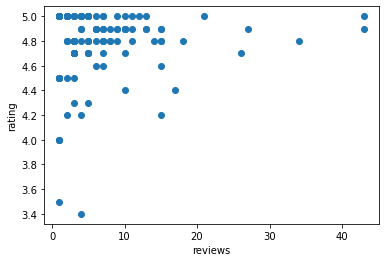

In [8]:
empresas_con_rating = companies.query('reviews != 0')
plt.scatter(empresas_con_rating.reviews, empresas_con_rating.rating)
plt.xlabel("reviews")
plt.ylabel("rating")
plt.show()

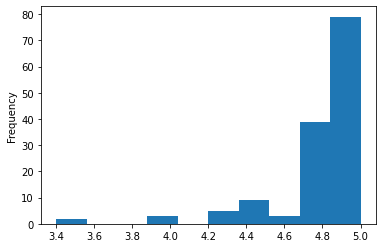

In [9]:
companies.query('rating != 0').rating.astype(float).plot.hist()
plt.show()

## Clustering?

Podriamos armar clusters de empresas para cuando el usuario elija una, le mostremos las caracteristicas de sus competidores mas similares.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from umap import UMAP

In [11]:
companies.columns

Index(['avg_hourly_rate', 'client_focus_enterprise_1b',
       'client_focus_midmarket_10m_1b', 'client_focus_small_business',
       'company_name', 'employees', 'location', 'min_project_size', 'rating',
       'reviews', 'service_focus_custom_software_development',
       'service_focus_digital_strategy', 'service_focus_ecommerce_development',
       'service_focus_it_managed_services',
       'service_focus_it_staff_augmentation',
       'service_focus_it_strategy_consulting',
       'service_focus_mobile_app_development',
       'service_focus_search_engine_optimization',
       'service_focus_social_media_marketing', 'service_focus_uxui_design',
       'service_focus_web_design', 'service_focus_web_development'],
      dtype='object')

In [14]:
columns_clustering = [
    columna for columna in companies.columns 
    if columna.startswith("service_") or columna.startswith("client_focus_")
]

In [15]:
columns_clustering

['client_focus_enterprise_1b',
 'client_focus_midmarket_10m_1b',
 'client_focus_small_business',
 'service_focus_custom_software_development',
 'service_focus_digital_strategy',
 'service_focus_ecommerce_development',
 'service_focus_it_managed_services',
 'service_focus_it_staff_augmentation',
 'service_focus_it_strategy_consulting',
 'service_focus_mobile_app_development',
 'service_focus_search_engine_optimization',
 'service_focus_social_media_marketing',
 'service_focus_uxui_design',
 'service_focus_web_design',
 'service_focus_web_development']

In [16]:
ss = StandardScaler()
x = companies[columns_clustering]
x = ss.fit_transform(x)

In [18]:
umap = UMAP(n_components=4, random_state=42)
x_reduced = umap.fit_transform(x)
df_reduced = pd.DataFrame(x_reduced)

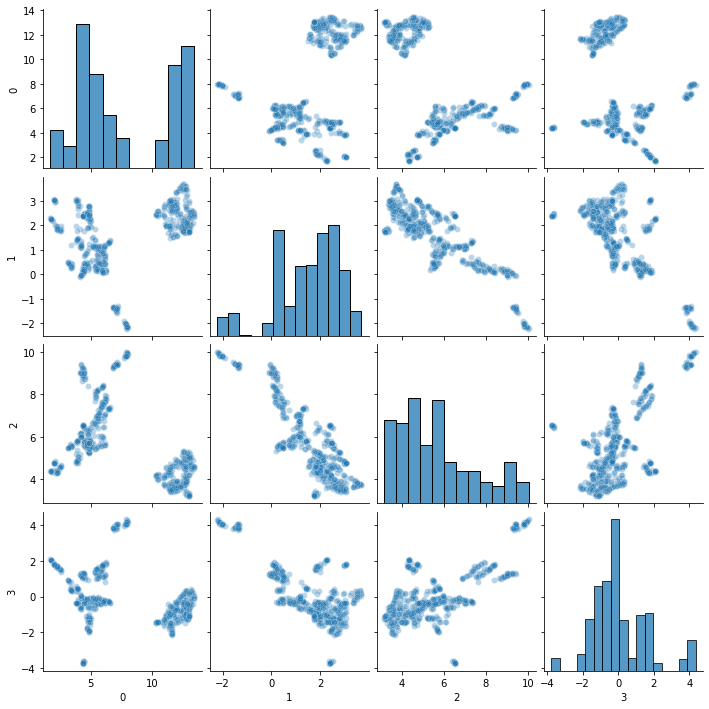

In [20]:
sns.pairplot(df_reduced, kind='scatter', plot_kws={'alpha':0.3})
plt.show()

In [21]:
clustering_model = KMeans(n_clusters=3, random_state=42)
df_reduced['cluster'] = clustering_model.fit_predict(df_reduced)

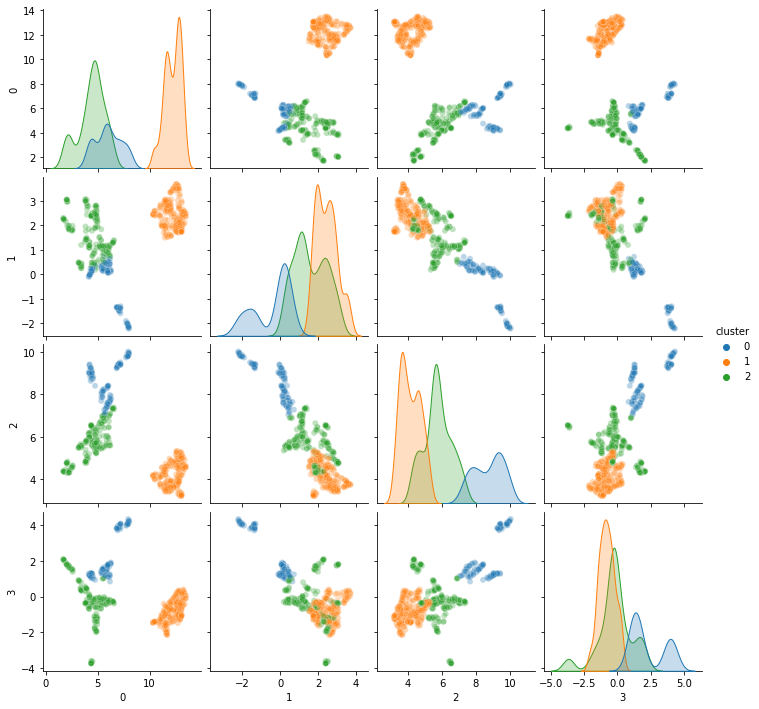

In [23]:
sns.pairplot(df_reduced, hue="cluster", kind='scatter', plot_kws={'alpha':0.3}, palette="tab10")
plt.show()

In [24]:
model = Pipeline(steps=[
    ("standard_scaler", ss),
    ("umap", umap),
    ("clustering", clustering_model)
])

In [147]:
import pickle

with open('model.pkl','wb') as f:
    pickle.dump(model, f)

In [25]:
companies["cluster"] = model.predict(companies[columns_clustering])

companies.to_csv('clutch_ar_companies_cluster.csv', index=False)
# companies = pd.read_csv('clutch_ar_companies_cluster.csv')

In [26]:
(
    companies
    .query('rating != 0')
    .cluster
    .value_counts(normalize=True)
)

1    0.807143
2    0.142857
0    0.050000
Name: cluster, dtype: float64

In [ ]:
companies["empresa"]

In [71]:
empresa = companies.query('company_name == "Flux IT"')

In [31]:
empresas_del_cluster = companies.query(f'cluster == {empresa.cluster}')

In [33]:
empresas_del_cluster.shape

(214, 23)

In [36]:
empresas_del_cluster.head()

,avg_hourly_rate,client_focus_enterprise_1b,client_focus_midmarket_10m_1b,client_focus_small_business,company_name,employees,location,min_project_size,rating,reviews,service_focus_custom_software_development,service_focus_digital_strategy,service_focus_ecommerce_development,service_focus_it_managed_services,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_mobile_app_development,service_focus_search_engine_optimization,service_focus_social_media_marketing,service_focus_uxui_design,service_focus_web_design,service_focus_web_development,cluster
0,37,10,80,10,404 // Software crafters,29,"Campo Salles, Argentina",10000,4.7,5,30,0,0,0,0,0,40,0,0,0,0,30,1
1,124,25,40,35,Rootstrap,149,"Buenos Aires, Argentina",50000,4.8,34,10,0,0,0,0,0,25,0,0,0,0,40,1
2,-1,25,50,25,Flux IT,149,"Gonnet, Argentina",10000,4.9,10,40,0,0,0,0,0,30,0,0,0,0,30,1
3,37,0,70,30,Clarika,149,"Córdoba, Argentina",10000,4.8,14,30,0,0,0,30,10,20,0,0,0,0,10,1
4,37,30,40,30,Azumo,149,"Rosario, Argentina",25000,4.9,10,20,0,0,0,0,0,10,0,0,0,0,20,1


In [56]:
import plotly.express as px

In [74]:
empresas_del_cluster_con_rating = empresas_del_cluster.query("rating != 0")
empresas_del_cluster_con_rating["referencia"] = "competencia"
empresas_del_cluster_con_rating.loc[empresa.index, ["referencia"]] = "nosotros"
empresas_del_cluster_con_rating = empresas_del_cluster_con_rating.sort_values(["referencia"], ascending=True)

In [87]:
fig = px.scatter(empresas_del_cluster_con_rating,
                 x="reviews",
                 y="rating", 
                 color="referencia", 
                 size="employees",
                 hover_name="company_name")
fig.update_layout(title='Empresas de IT similares a Flux IT')
fig.show()

In [94]:
columnas_client_focus = ["company_name", "client_focus_enterprise_1b", "client_focus_midmarket_10m_1b", "client_focus_small_business"]
companies["client_focus_sum"] = companies.client_focus_enterprise_1b + companies.client_focus_midmarket_10m_1b + companies.client_focus_small_business
companies_client_focus = companies.query("client_focus_sum > 0")

In [102]:
from sklearn.decomposition import PCA

In [106]:
pca = PCA(n_components=2)
x = companies_client_focus[columnas_client_focus].drop(columns=["company_name"])
x = pca.fit_transform(x)

In [136]:
companies_client_focus_pca = pd.DataFrame(x)
companies_client_focus_pca.columns = ["0", "1"]
companies_client_focus_pca.index = companies_client_focus.index
companies_client_focus_pca["company_name"] = companies_client_focus["company_name"]
companies_client_focus_pca["enterprise"] = companies_client_focus["client_focus_enterprise_1b"].astype(str) + "%"
companies_client_focus_pca["midmarket"] = companies_client_focus["client_focus_midmarket_10m_1b"].astype(str) + "%"
companies_client_focus_pca["small_business"] = companies_client_focus["client_focus_small_business"].astype(str) + "%"
companies_client_focus_pca["referencia"] = "competencia"
companies_client_focus_pca.loc[empresa.index, ["referencia"]] = "nosotros"
companies_client_focus_pca = companies_client_focus_pca.sort_values(["referencia"], ascending=True)
companies_client_focus_pca["0"] = companies_client_focus_pca["0"] - companies_client_focus_pca.iloc[empresa.index]["0"].values[0]
companies_client_focus_pca["1"] = companies_client_focus_pca["1"] - companies_client_focus_pca.iloc[empresa.index]["1"].values[0]

In [128]:
companies_client_focus_pca.iloc[empresa.index]

,0,1,company_name,enterprise,midmarket,small_business,referencia
276,-13.754314,-22.877618,SSA Group,11%,59%,30%,competencia


In [134]:
companies_client_focus_pca.iloc[empresa.index]["0"].values[0]

-13.754314307698497

In [135]:
companies_client_focus_pca["0"] - companies_client_focus_pca.iloc[empresa.index]["0"].values[0]

0     -22.233523
275    13.258004
276     0.000000
277   -18.471465
278   -22.233523
280    20.743963
281    35.677723
282   -18.471465
283     2.998199
284   -24.095473
285    57.166465
286   -25.957424
274   -46.477035
287     9.534104
289   -12.866536
290    -5.399656
291    35.677723
293    46.887582
294    58.097441
297   -40.891184
298   -18.471465
299   -31.543275
300    58.097441
306    58.097441
312    46.887582
288    46.887582
321    80.517159
268    -1.656677
245    18.882012
207    -3.537706
208     7.672153
210    34.746747
211   -18.471465
212    80.517159
215    24.467863
217   -16.609515
218    11.396054
219    57.166465
221    41.282652
224    17.000984
253    32.884797
225   -25.007370
228    33.815772
229   -37.167283
230    35.677723
231   -15.678540
232    35.677723
234    62.771395
235    58.097441
236    19.812988
241     1.136249
242    -9.161714
244    13.258004
226    24.467863
205    33.815772
335     9.534104
343    -0.919528
445    46.887582
446   -16.6095

In [123]:
fig = px.scatter(companies_client_focus_pca,
                 x="0",
                 y="1", 
                 color="referencia", 
                hover_name="company_name",
                hover_data=["enterprise", "midmarket", "small_business"])
fig.update_layout(title='Empresas de IT similares a Flux IT', xaxis_title="", yaxis_title="")
fig.show()

In [68]:
empresas_del_cluster_con_rating.describe()

,avg_hourly_rate,client_focus_enterprise_1b,client_focus_midmarket_10m_1b,client_focus_small_business,employees,min_project_size,rating,reviews,service_focus_custom_software_development,service_focus_digital_strategy,service_focus_ecommerce_development,service_focus_it_managed_services,service_focus_it_staff_augmentation,service_focus_it_strategy_consulting,service_focus_mobile_app_development,service_focus_search_engine_optimization,service_focus_social_media_marketing,service_focus_uxui_design,service_focus_web_design,service_focus_web_development,cluster
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.0
mean,50.194690,18.088496,39.548673,42.362832,293.557522,13699.044248,4.802655,6.681416,24.469027,0.486726,2.477876,1.212389,8.061947,1.371681,16.929204,0.265487,0.221239,5.398230,1.548673,18.035398,1.0
std,24.804183,20.742278,19.315977,27.579127,885.124527,16483.755289,0.286126,7.672150,18.973229,2.311134,7.261810,4.154282,15.731158,4.238840,14.700411,2.095990,1.399837,10.289158,4.958743,16.739565,0.0
min,-1.000000,0.000000,0.000000,0.000000,5.000000,-1.000000,3.400000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,37.000000,0.000000,30.000000,20.000000,29.000000,5000.000000,4.700000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,37.000000,10.000000,40.000000,40.000000,149.000000,10000.000000,4.900000,4.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.0
75%,74.000000,30.000000,50.000000,65.000000,149.000000,25000.000000,5.000000,9.000000,35.000000,0.000000,0.000000,0.000000,10.000000,0.000000,30.000000,0.000000,0.000000,10.000000,0.000000,30.000000,1.0
max,124.000000,80.000000,80.000000,100.000000,5499.000000,100000.000000,5.000000,43.000000,80.000000,15.000000,60.000000,20.000000,70.000000,25.000000,60.000000,20.000000,10.000000,50.000000,30.000000,80.000000,1.0


-agregar las categorias: web, software dev(ya esta), mobiel
- eliminar duplicados
- elegir una empresa
- sacar client focus
- filtrar aquellas empresas que al menos dos principales (de mayor porcentaje) de las caracteristicas.
- armar métrica de diferencia: cantidad de empleados maximo y restar la elegida, lo mismo con min project size, mismo tarifa. ¿armamos una sola metrica con las tres o las tres por separadas?
- 
- graficar